In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sys, os, datetime
import h5py
from tqdm import tqdm
import dask
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline

In [2]:
import h5netcdf

In [3]:
import flox

In [4]:
hdf5_file_path = "/home/axb170054/scratch/tec-stuff/hdf5/los_20130317.002.h5.hdf5"


In [70]:
cols = ['year', 'month', 'day', 'hour', 'min', 'sec', 'recno', 'kindat', 'kinst', 'ut1_unix', 'ut2_unix', 'pierce_alt', 'gps_site', 'sat_id', 'gnss_type', 'gdlatr', 'gdlonr', 'galtr', 'los_tec', 'dlos_tec', 'tec', 'azm', 'elm', 'gdlat', 'glon', 'rec_bias', 'drec_bias']

In [6]:
# cols = ['ut1_unix', 'ut2_unix', 'gps_site', 'sat_id', 'gdlatr', 'gdlonr', 'galtr', 'los_tec', 'dlos_tec', 'tec', 'azm', 'elm', 'gdlat', 'glon']

In [71]:
# Read the GNSS HDF5 file into xarray - only taking the data we want.
with h5py.File(hdf5_file_path, 'r') as file:
    data_group = file['Data']
    data_array = data_group['Table Layout'][:]
    
    bigds = xr.Dataset(
        {name: (['idx'], data_array[name]) for name in cols},
    )

In [72]:
bigds['time'] = ('idx'), pd.to_datetime(bigds.ut1_unix, unit='s')
bigds['time2'] = ('idx'), pd.to_datetime(bigds.ut2_unix, unit='s')


In [73]:
bigds

<xarray.Dataset>
Dimensions:     (idx: 146558284)
Dimensions without coordinates: idx
Data variables: (12/29)
    year        (idx) int64 2013 2013 2013 2013 2013 ... 2013 2013 2013 2013
    month       (idx) int64 3 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3 3
    day         (idx) int64 17 17 17 17 17 17 17 17 ... 17 17 17 17 17 17 17 17
    hour        (idx) int64 0 0 0 0 0 0 0 0 0 0 ... 23 23 23 23 23 23 23 23 23
    min         (idx) int64 0 0 0 0 0 0 0 0 0 0 ... 59 59 59 59 59 59 59 59 59
    sec         (idx) int64 0 0 0 0 0 0 0 0 0 0 ... 30 30 30 30 30 30 30 30 30
    ...          ...
    gdlat       (idx) float64 -8.588 -11.28 -8.749 -13.86 ... 50.06 50.25 45.99
    glon        (idx) float64 131.9 133.9 138.2 131.7 ... 22.65 16.53 13.27
    rec_bias    (idx) float64 -23.44 1.106 1.995 -3.974 ... -37.51 -36.78 -44.28
    drec_bias   (idx) float64 1.304 1.308 1.308 1.304 ... 1.301 1.302 1.304
    time        (idx) datetime64[ns] 2013-03-17 ... 2013-03-17T23:59:30
    time2       (idx) datetime64[ns] 2013-03-17T00:00:01 ... 2013-03-17T23:59:31

In [74]:
lilds = bigds.where(bigds.time<pd.Timestamp('2013-03-17 00:30:00'), drop=True)

In [79]:
lilds.year.astype(int).astype(str).values, lilds.month.astype(int).astype(str).values

(array(['2013', '2013', '2013', ..., '2013', '2013', '2013'], dtype='<U21'),
 array(['3', '3', '3', ..., '3', '3', '3'], dtype='<U21'))

In [116]:
dt = np.array([lilds['year'].values, lilds.month.values, lilds.day.values, lilds.hour.values, lilds['min'].values, lilds.sec.values]).astype(int).T.astype(str)

In [117]:
dt.shape

(3181843, 6)

In [126]:
dto = []

for j in range (len(dt)):

    dto.append(pd.Timestamp(dt[j,0]+dt[j,1].rjust(2,'0')+dt[j,2]+' '+dt[j,3]+':'+dt[j,4]+':'+dt[j,5]))

In [127]:
dto[:5]

[Timestamp('2013-03-17 00:00:00'),
 Timestamp('2013-03-17 00:00:00'),
 Timestamp('2013-03-17 00:00:00'),
 Timestamp('2013-03-17 00:00:00'),
 Timestamp('2013-03-17 00:00:00')]

In [140]:
np.sum(np.array(dto).astype(np.datetime64) == lilds.time.values)

3181843

In [141]:
len(dto)

3181843

In [129]:
bigds['idx'] = range(data_array.shape[0])

In [130]:
bigds

<xarray.Dataset>
Dimensions:   (idx: 146558284)
Coordinates:
  * idx       (idx) int64 0 1 2 3 4 ... 146558280 146558281 146558282 146558283
Data variables: (12/14)
    ut1_unix  (idx) float64 1.363e+09 1.363e+09 ... 1.364e+09 1.364e+09
    gps_site  (idx) |S4 b'00na' b'00na' b'00na' ... b'zywi' b'zywi' b'zywi'
    sat_id    (idx) int64 2 4 8 9 12 15 17 24 26 ... 17 18 18 19 21 25 29 30 31
    gdlatr    (idx) float64 -12.47 -12.47 -12.47 -12.47 ... 49.69 49.69 49.69
    gdlonr    (idx) float64 130.8 130.8 130.8 130.8 ... 19.21 19.21 19.21 19.21
    galtr     (idx) float64 0.1048 0.1048 0.1048 0.1048 ... 0.4128 0.4128 0.4128
    ...        ...
    tec       (idx) float64 24.2 20.92 19.89 17.78 ... 7.2 2.643 2.103 6.584
    azm       (idx) float64 15.18 68.92 63.54 148.5 ... 144.7 79.0 -70.57 -130.5
    elm       (idx) float64 35.53 41.89 16.66 61.09 ... 18.39 52.47 58.34 26.8
    gdlat     (idx) float64 -8.588 -11.28 -8.749 -13.86 ... 50.06 50.25 45.99
    glon      (idx) float64 131.9 133.9 138.2 131.7 ... 25.19 22.65 16.53 13.27
    time      (idx) datetime64[ns] 2013-03-17 2013-03-17 ... 2013-03-17T23:59:30

In [23]:
bigds.nbytes/1024**3

16.925136759877205

In [24]:
%time gpsbiglist = list(bigds.groupby('gps_site'))

CPU times: user 7min 15s, sys: 28.1 s, total: 7min 43s
Wall time: 7min 42s


In [259]:
# np.linspace(



In [272]:
times = []
out_lat  = []
out_lon  = []
out_tec  = []
out_dtec = []
out_los = []

skipped=0

xout = pd.date_range(bigds.time.min().values, bigds.time.max().values, 2880)

for n, d in tqdm(gpsbiglist):
    d2 = d.groupby('sat_id')
    
    for sat_num, d3 in d2:
        
        
        first=True
    
        splits = np.where((d3.time.diff('idx').astype(int) > 3600*1e9))

        for s in splits:
            data = {}
            
            for v in d3.data_vars:
                data[v] = np.split(d3[v].values, s+1)
                
            for ipass in range(len(data['dlos_tec'])):
                
                
                sel = np.where((data['dlos_tec'][ipass] < 1))
                
    
                if len(sel[0]) > 20:
                    xin = data['time'][ipass][sel].astype(int)
                    
                    num_secs = pd.Timedelta(xin[-1] - xin[0]).total_seconds()

                    if num_secs > 1800:

                        yin = data['los_tec'][ipass][sel]

                        
                        _,in_idx = np.unique(xin, return_index=True)
                        
                        if len(in_idx) != len(xin):
                            skipped +=1

                            continue
                        
                        yout = CubicSpline(xin, yin)(xout, extrapolate=False)

                        fit = np.empty(yout.shape)
                        
                        fit[~np.isnan(yout)] = savgol_filter(yout[~np.isnan(yout)], 60, 1, mode='interp')

                        out_dtec.append(yout - fit)
                        out_lat.append(CubicSpline(xin, data['gdlat'][ipass][sel])(xout, extrapolate=False))
                        out_lon.append(CubicSpline(xin, data['glon'][ipass][sel])(xout, extrapolate=False))
                        # times.extend(xout)
                        out_tec.append(CubicSpline(xin, data['tec'][ipass][sel])(xout, extrapolate=False))
                        out_los.append(CubicSpline(xin, data['los_tec'][ipass][sel])(xout, extrapolate=False))
                                       
                        # raise
                    # raise


    
    
    # break
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5547/5547 [29:30<00:00,  3.13it/s]


In [273]:
skipped

42647

In [274]:
fits = xr.Dataset()

In [280]:
fits['time'] = 'time', xout
fits['glat'] = ('idx', 'time'), out_lat
fits['glon'] =('idx', 'time'), out_lon
fits['tec'] = ('idx', 'time'), out_tec
fits['dtec'] = ('idx', 'time'), out_dtec

In [281]:
fits

<xarray.Dataset>
Dimensions:  (time: 2880, idx: 270659)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-17 ... 2013-03-17T23:59:30
Dimensions without coordinates: idx
Data variables:
    glat     (idx, time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    glon     (idx, time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    tec      (idx, time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dtec     (idx, time) float64 nan nan nan nan nan nan ... nan nan nan nan nan

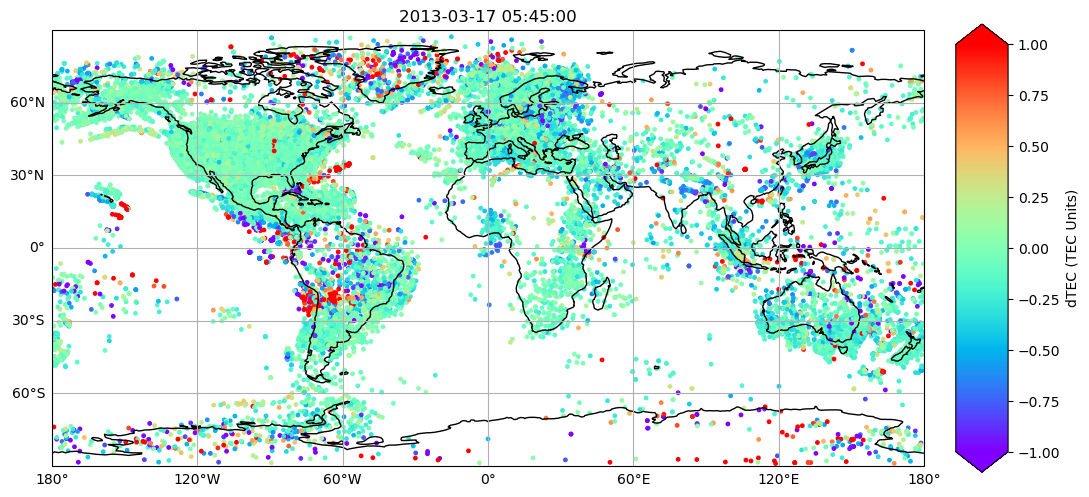

In [327]:
t_step = 690

t_ds = fits.isel(time = t_step)



fig, axs = plt.subplots(1, 2, width_ratios=(1,.06), figsize=(11,5), 
                        subplot_kw={'projection':ccrs.PlateCarree()})
# ax0 = fig.add_subplot(1,5,, projection=ccrs.PlateCarree())

axs[1].remove()
axs[1] = fig.add_subplot(1,2,2)


f = axs[0].scatter(t_ds.glon, t_ds.glat, c=t_ds.dtec, 
                   vmin=-1, vmax=1, s=6, cmap='rainbow')

axs[0].coastlines()
axs[0].gridlines(draw_labels=['bottom', 'left'])
axs[0].set_title(t_ds.time.dt.strftime('%Y-%m-%d %H:%M:%S').values)

plt.colorbar(f, cax=axs[1], label='dTEC (TEC Units)', extend='both')

# axs[0].ccrs.PlateCarree()

fig.tight_layout()
fig.show();

In [328]:
fits.time.size

2880

In [335]:
%time t_dss = list(fits.groupby('time'))

CPU times: user 1.03 s, sys: 29 ms, total: 1.06 s
Wall time: 1.05 s


In [339]:


for t_num, (t_step, t_ds) in enumerate(tqdm(t_dss)):
    
    # t_step = 690

    # t_ds = fits.isel(time = t_step)



    fig, axs = plt.subplots(1, 2, width_ratios=(1,.06), figsize=(11,5), 
                            subplot_kw={'projection':ccrs.PlateCarree()})
    # ax0 = fig.add_subplot(1,5,, projection=ccrs.PlateCarree())

    axs[1].remove()
    axs[1] = fig.add_subplot(1,2,2)


    f = axs[0].scatter(t_ds.glon, t_ds.glat, c=t_ds.dtec, 
                       vmin=-1, vmax=1, s=6, cmap='rainbow')

    axs[0].coastlines()
    axs[0].gridlines(draw_labels=['bottom', 'left'])
    axs[0].set_title(pd.to_datetime(t_step).strftime('%Y-%m-%d %H:%M:%S'))

    plt.colorbar(f, cax=axs[1], label='dTEC (TEC Units)', extend='both')

    # axs[0].ccrs.PlateCarree()

    fig.tight_layout()
    fig.savefig('los_plots/'+str(t_num).rjust(4,'0'))
    
    plt.close('all');
    
    # break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2880/2880 [1:36:24<00:00,  2.01s/it]


In [341]:
fits.to_netcdf('../../scratch/tec-stuff/fit03-17.nc')

In [342]:
fits

<xarray.Dataset>
Dimensions:  (time: 2880, idx: 270659)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-17 ... 2013-03-17T23:59:30
Dimensions without coordinates: idx
Data variables:
    glat     (idx, time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    glon     (idx, time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    tec      (idx, time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dtec     (idx, time) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [343]:
lilds

<xarray.Dataset>
Dimensions:     (idx: 3181843)
Dimensions without coordinates: idx
Data variables: (12/29)
    year        (idx) float64 2.013e+03 2.013e+03 ... 2.013e+03 2.013e+03
    month       (idx) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0
    day         (idx) float64 17.0 17.0 17.0 17.0 17.0 ... 17.0 17.0 17.0 17.0
    hour        (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    min         (idx) float64 0.0 0.0 0.0 0.0 0.0 ... 29.0 29.0 29.0 29.0 29.0
    sec         (idx) float64 0.0 0.0 0.0 0.0 0.0 ... 30.0 30.0 30.0 30.0 30.0
    ...          ...
    gdlat       (idx) float64 -8.588 -11.28 -8.749 -13.86 ... 49.7 49.56 43.42
    glon        (idx) float64 131.9 133.9 138.2 131.7 ... 24.19 17.03 11.63
    rec_bias    (idx) float64 -23.44 1.106 1.995 -3.974 ... -37.51 -36.78 -44.28
    drec_bias   (idx) float64 1.304 1.308 1.308 1.304 ... 1.301 1.302 1.304
    time        (idx) datetime64[ns] 2013-03-17 ... 2013-03-17T00:29:30
    time2       (idx) datetime64[ns] 2013-03-17T00:00:01 ... 2013-03-17T00:29:31

In [278]:
len(data['los_tec'][ipass][sel])

456

In [279]:
len(out_dtec), len(times), len(out_lon)

(270659, 0, 270659)

In [213]:
fits = xr.Dataset()

In [214]:
fits['time'] = 'time', pd.to_datetime(times)
fits['glat'] = 'time', out_lat
fits['glon'] = 'time', out_lon
fits['tec'] = 'time', out_tec
fits['dtec'] = 'time', out_dtec

In [215]:
fits

<xarray.Dataset>
Dimensions:  (time: 130772095)
Coordinates:
  * time     (time) float64 1.364e+18 1.364e+18 ... 1.364e+18 1.364e+18
Data variables:
    glat     (time) float64 -19.78 -19.68 -19.65 -19.64 ... 42.53 42.5 42.45
    glon     (time) float64 125.7 125.8 125.8 125.8 ... 34.23 34.33 34.36 34.41
    tec      (time) float64 26.13 26.42 26.53 26.6 ... 46.42 46.52 46.55 46.59
    dtec     (time) float64 -2.25 -1.974 -1.742 -1.545 ... 0.9975 0.4785 0.2043

In [216]:
fits['time'] = pd.to_datetime(fits.time.values)

In [217]:
fits

<xarray.Dataset>
Dimensions:  (time: 130772095)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-17T11:57:30 ... 2013-03-17T10:36:00
Data variables:
    glat     (time) float64 -19.78 -19.68 -19.65 -19.64 ... 42.53 42.5 42.45
    glon     (time) float64 125.7 125.8 125.8 125.8 ... 34.23 34.33 34.36 34.41
    tec      (time) float64 26.13 26.42 26.53 26.6 ... 46.42 46.52 46.55 46.59
    dtec     (time) float64 -2.25 -1.974 -1.742 -1.545 ... 0.9975 0.4785 0.2043

In [243]:
%time fits.where(fits.time == fits.time.values[0], drop=True)

CPU times: user 3.22 s, sys: 2.53 s, total: 5.74 s
Wall time: 5.74 s


<xarray.Dataset>
Dimensions:  (time: 316)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-17T11:57:30 ... 2013-03-17T11:57:30
Data variables:
    glat     (time) float64 -19.78 -19.82 -19.66 71.55 ... 41.39 30.11 43.79
    glon     (time) float64 125.7 125.8 125.7 16.82 ... -67.24 -114.9 -10.12
    tec      (time) float64 26.13 24.74 26.25 13.02 ... 10.31 14.01 7.699 36.28
    dtec     (time) float64 -2.25 -1.987 -2.159 -2.573 ... 1.885 -0.5043 -0.7704

In [244]:
%time t_dss = list(fits.groupby('time'))

KeyboardInterrupt: 

In [ ]:
len(t_dss)

In [ ]:
len(t_dss) * 5.7 /60

In [242]:
t_dss[69]

NameError: name 't_dss' is not defined

In [238]:
time_opts = np.unique(fits.time.values)


KeyboardInterrupt



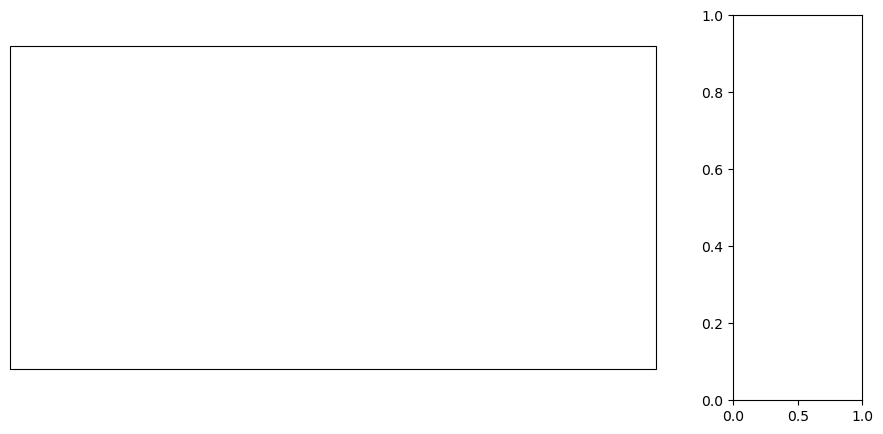

In [239]:
t_step = 69


t_val = time_opts[t_step]


fig, axs = plt.subplots(1, 2, width_ratios=(1,.2), figsize=(11,5), 
                        subplot_kw={'projection':ccrs.PlateCarree()})
# ax0 = fig.add_subplot(1,5,, projection=ccrs.PlateCarree())

axs[1].remove()
axs[1] = fig.add_subplot(1,2,2)

t_ds = fits.where(fits.time == t_val)

axs[0].scatter(t_ds.glon, t_ds.glat, c=t_ds.dtec)

# axs[0].ccrs.PlateCarree()


fig.show()

In [167]:
xin = data['time'][ipass].astype(int)
xin2 = data['time2'][ipass].astype(int)

In [168]:
_,in_idx = np.unique(np.flip(xin), return_index=True)

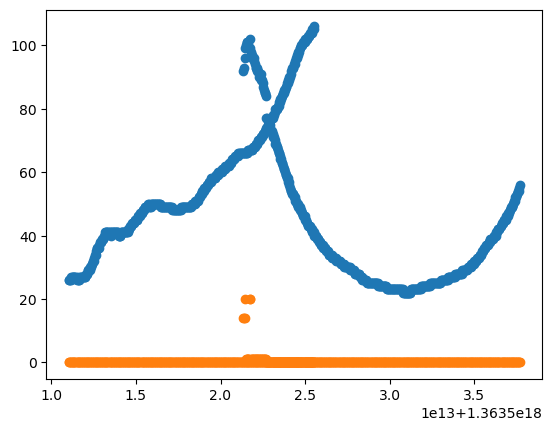

In [170]:
plt.scatter(xin,data['los_tec'][ipass].astype(int))
plt.scatter(xin,data['dlos_tec'][ipass].astype(int))

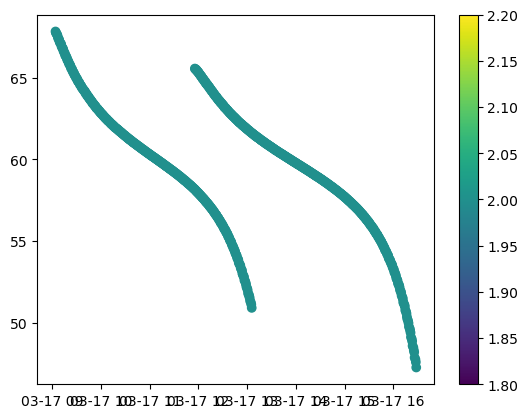

In [195]:
# plt.plot(data['gdlat'][ipass][sel], data['los_tec'][ipass][sel])
plt.scatter(data['time'][ipass], data['gdlat'][ipass], c=data['sat_id'][ipass])
plt.colorbar()

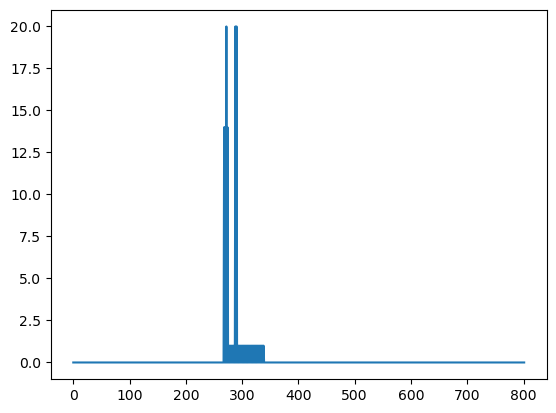

In [45]:
plt.plot(data['dlos_tec'][ipass][sel].astype(int))

In [499]:
len(out_dtec), len(times), len(out_lon)

(636, 496, 496)

In [492]:
len(sel[0])

468

In [493]:
len(out_dtec)

172306820

In [494]:
fits = xr.Dataset()

In [496]:
fits['time'] = ('time', times)
fits['glat'] = 'time', out_lat
fits['glon'] = 'time', out_lon
fits['tec'] = 'time', out_tec
fits['dtec'] = 'time', out_dtec

ValueError: conflicting sizes for dimension 'time': length 172306820 on 'dtec' and length 145660583 on {'time': 'time'}

In [ ]:
fits

In [483]:
len(np.unique(fits.time))

2880

In [487]:
fits.time.size - fits.dtec.size

-26646237

In [488]:
fits.sizes

Frozen({'time': 145660583, 'glat': 145660583, 'glon': 145660583, 'tec': 145660583, 'dtec': 172306820})

In [255]:
%time splits = np.where((d2[3].time.diff('idx').astype(int) > 3600*1e9))

CPU times: user 12.2 ms, sys: 2.01 ms, total: 14.2 ms
Wall time: 12.1 ms


In [256]:

tec = np.split(d2[3].los_tec.values, splits[0]+1)

tec2 = np.split(d2[3].tec.values, splits[0]+1)


glat = np.split(d2[3].gdlat.values, splits[0]+1)
glon = np.split(d2[3].glon.values, splits[0]+1)

time = np.split(d2[3].time.values, splits[0]+1)

az = np.split(d2[3].azm.values, splits[0]+1)
el = np.split(d2[3].elm.values, splits[0]+1)



In [346]:
for s in splits:
    data = {}
    for v in d2[3].data_vars:
        data[v] = np.split(d2[3][v].values, s+1)
        

In [347]:
sel = np.where(data['dlos_tec'][0] < 1)

In [364]:
xin = data['time'][0][sel].astype(int)
yin = data['los_tec'][0][sel]

In [365]:
total_outs = round((xin[-1] - xin[0])/30e9)

In [366]:
total_outs

612

In [367]:
xout = np.linspace(xin[0], xin[-1], total_outs)

In [375]:

yout = CubicSpline(xin, yin)(xout)

CPU times: user 2.1 ms, sys: 7 µs, total: 2.11 ms
Wall time: 1.74 ms


In [369]:
fit = savgol_filter(yout, 60, 1, mode='interp')
fit2 = savgol_filter(yin, 60, 1, mode='interp')


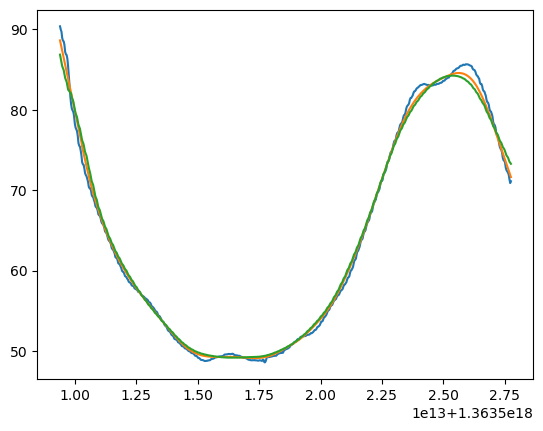

In [370]:
plt.plot(xout, yout)
plt.plot(xout, fit)
plt.plot(xin, fit2)

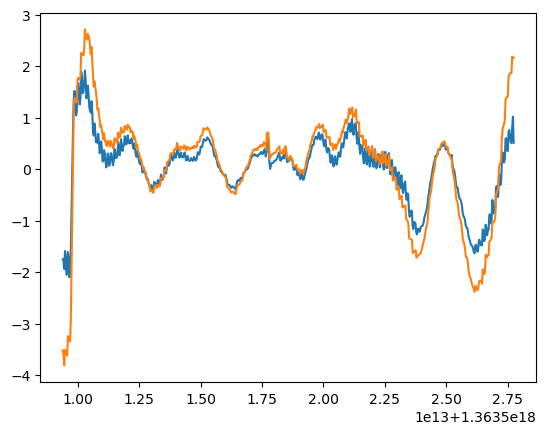

In [371]:
plt.plot(xout, fit-yout)
plt.plot(xin, fit2-yin)

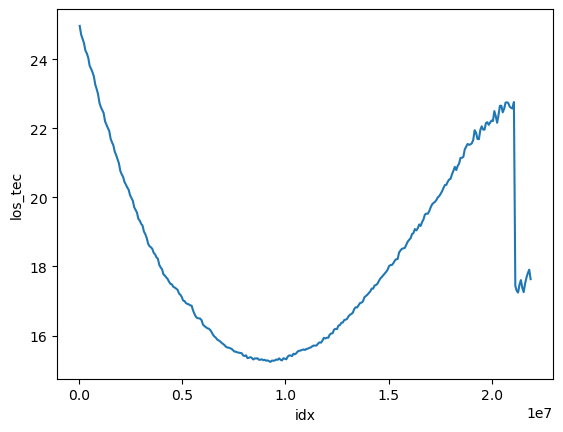

In [197]:
d3.los_tec.plot()

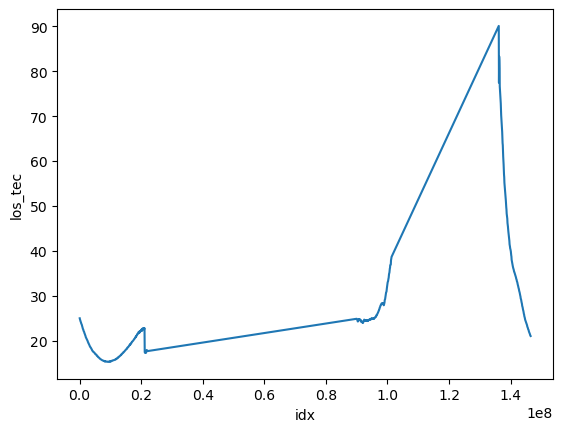

In [198]:
d2[3].los_tec.plot()

In [138]:
for n, d in enumerate(tqdm(gpslist)):
    sat_gps0 = list(d[1].groupby('sat_id'))

    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5503/5503 [01:09<00:00, 78.98it/s]


In [139]:
for n, d in enumerate(tqdm(satlist)):
    gps_sat0 = list(d[1].groupby('gps_site'))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:19<00:00,  2.58s/it]


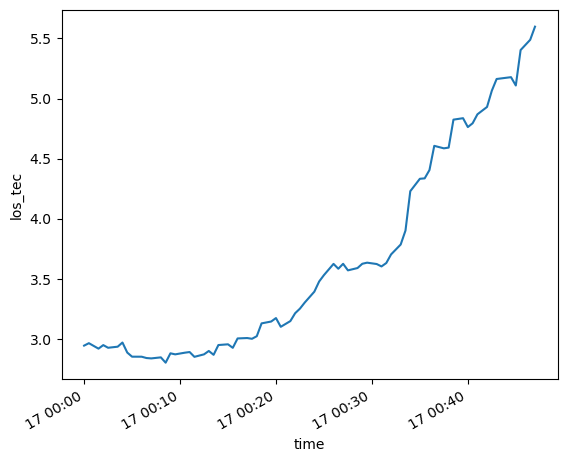

In [67]:
gps_sat0[0][1].swap_dims(idx='time').los_tec.plot(x='time')

In [143]:
%time gps_0 = bigds.gps_site.values[0]
%time sat_0 = bigds.sat_id.values[0]

CPU times: user 219 µs, sys: 16 µs, total: 235 µs
Wall time: 257 µs
CPU times: user 98 µs, sys: 0 ns, total: 98 µs
Wall time: 103 µs


In [77]:
%time sat0ds = bigds.swap_dims(idx='sat_id').sel(sat_id=sat_0)
%time gps0ds = bigds.swap_dims(idx='gps_site').sel(gps_site=gps_0)

CPU times: user 15.5 s, sys: 131 ms, total: 15.6 s
Wall time: 15.6 s
CPU times: user 25.9 s, sys: 4.96 s, total: 30.8 s
Wall time: 30.6 s


In [78]:
%time sat0ds0 = sat0ds.swap_dims(sat_id='gps_site').sel(gps_site=gps_0)
%time gps0ds0 = gps0ds.swap_dims(gps_site='sat_id').sel(sat_id=sat_0)

CPU times: user 946 ms, sys: 19.3 ms, total: 966 ms
Wall time: 961 ms
CPU times: user 3.84 ms, sys: 0 ns, total: 3.84 ms
Wall time: 3.58 ms


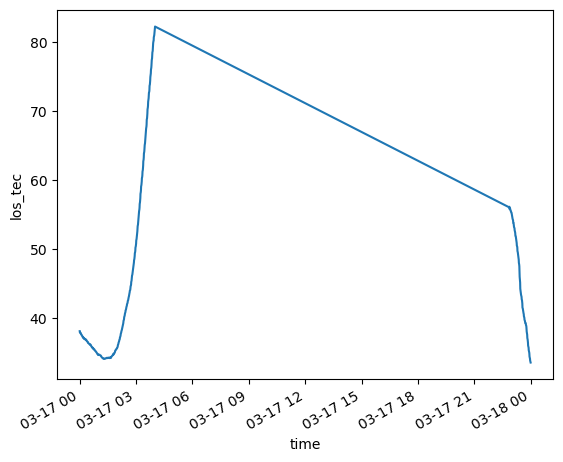

In [80]:
sat0ds0.swap_dims(gps_site='time').los_tec.plot()

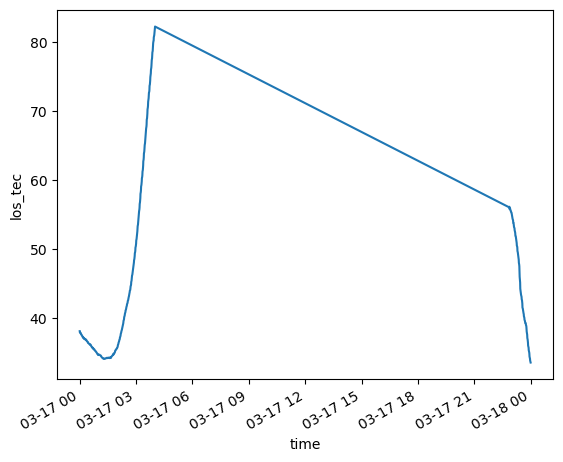

In [82]:
gps0ds0.swap_dims(sat_id='time').los_tec.plot()

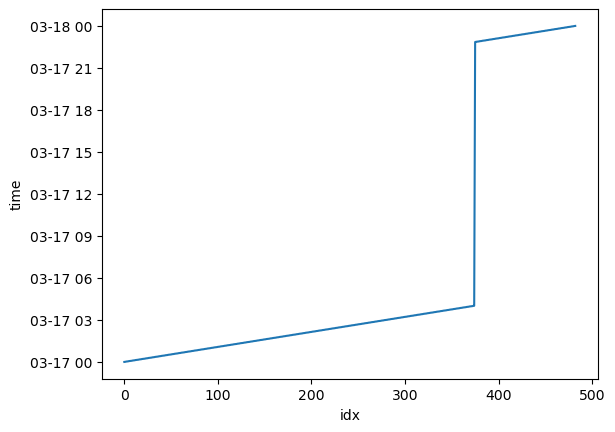

In [93]:
gps0ds0.time.swap_dims(sat_id='idx').plot()

In [122]:
tvals = gps0ds0.time.values
rindx = np.where(np.diff(tvals).astype(int) > 1e11)

In [123]:
rindx, rindx[0], rindx[0][0]

((array([374]),), array([374]), 374)

In [ ]:
for i in rindx[0]:
    sel_ds = 

In [118]:
np.split(tvals, rindx[0]+1)

[array(['2013-03-17T00:00:00.000000000', '2013-03-17T00:00:30.000000000',
        '2013-03-17T00:01:30.000000000', '2013-03-17T00:02:00.000000000',
        '2013-03-17T00:02:30.000000000', '2013-03-17T00:03:30.000000000',
        '2013-03-17T00:04:00.000000000', '2013-03-17T00:04:30.000000000',
        '2013-03-17T00:05:00.000000000', '2013-03-17T00:06:00.000000000',
        '2013-03-17T00:06:30.000000000', '2013-03-17T00:07:00.000000000',
        '2013-03-17T00:08:00.000000000', '2013-03-17T00:08:30.000000000',
        '2013-03-17T00:09:00.000000000', '2013-03-17T00:09:30.000000000',
        '2013-03-17T00:10:30.000000000', '2013-03-17T00:11:00.000000000',
        '2013-03-17T00:11:30.000000000', '2013-03-17T00:12:30.000000000',
        '2013-03-17T00:13:00.000000000', '2013-03-17T00:13:30.000000000',
        '2013-03-17T00:14:00.000000000', '2013-03-17T00:15:00.000000000',
        '2013-03-17T00:15:30.000000000', '2013-03-17T00:16:00.000000000',
        '2013-03-17T00:17:00.000000000

In [ ]:
gps[0]

In [56]:
?iter

Docstring:
iter(iterable) -> iterator
iter(callable, sentinel) -> iterator

Get an iterator from an object.  In the first form, the argument must
supply its own iterator, or be a sequence.
In the second form, the callable is called until it returns the sentinel.
Type:      builtin_function_or_method

In [58]:
l = [1,2,34,4]
for i in iter(l):
    print(i)

1
2
34
4


In [38]:
ds0 = ds.stack(idx=('sat_id', 'time'))

KeyError: 'sat_id'

In [35]:
ds.where(ds.ut1_unix==ds.ut1_unix[0], drop=True)

<xarray.Dataset>
Dimensions:     (idx: 69168)
Dimensions without coordinates: idx
Data variables: (12/27)
    year        (idx) float64 2.013e+03 2.013e+03 ... 2.013e+03 2.013e+03
    month       (idx) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0
    day         (idx) float64 17.0 17.0 17.0 17.0 17.0 ... 17.0 17.0 17.0 17.0
    hour        (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    min         (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sec         (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...          ...
    azm         (idx) float64 15.18 68.92 63.54 148.5 ... 77.74 -68.43 -129.3
    elm         (idx) float64 35.53 41.89 16.66 61.09 ... 19.98 53.94 57.09 28.2
    gdlat       (idx) float64 -8.588 -11.28 -8.749 -13.86 ... 50.09 50.35 46.25
    glon        (idx) float64 131.9 133.9 138.2 131.7 ... 22.47 16.43 13.43
    rec_bias    (idx) float64 -23.44 1.106 1.995 -3.974 ... -37.51 -36.78 -44.28
    drec_bias   (idx) float64 1.304 1.308 1.308 1.304 ... 1.301 1.302 1.304

In [ ]:
# Read the HDF5 file using h5py
with h5py.File(hdf5_file_path, 'r') as file:
    # Access the 'Table Layout' dataset within the '/Data' group
    table_layout = file['/Data/Table Layout']

    # Convert the dataset to a pandas DataFrame
    df = pd.DataFrame(table_layout[:])

# Set up the desired coordinates for reindexing
desired_coords = ['time', 'sat_id', 'gps_site']

# Set 'idx' as the index
df.set_index('idx', inplace=True)

# Reindex the DataFrame using the desired coordinates
df_reindexed = df.set_index(desired_coords)

In [9]:
all_data = {}

for c in cols:
    all_data[c] = []


In [19]:
ds = xr.Dataset()


In [21]:
import h5py
import xarray as xr

# Specify the path to your HDF5 file

# Read the HDF5 file using h5py
with h5py.File(hdf5_file_path, 'r') as file:
    # Access the 'Table Layout' dataset within the '/Data' group
    table_layout = file['/Data/Table Layout']

    # Extract variable names and data types
    variable_info = [(name, dtype) for name, dtype in table_layout.dtype.descr]

    # Extract data into a NumPy array
    data_array = table_layout[()]

    # Create xarray dataset with 'col_name' as the coordinate
    ds = xr.Dataset(
        {name: (['idx'], data_array[name]) for name, _ in variable_info},
        coords={'idx': range(data_array.shape[0])},
    )

    # Set attributes if needed
    # ds.attrs['attribute_name'] = 'attribute_value'

# Print the xarray dataset
# print(ds)


In [ ]:
# Read the HDF5 file using h5py
with h5py.File(hdf5_file_path, 'r') as file:
    # Access the 'Table Layout' dataset within the '/Data' group
    table_layout = file['/Data/Table Layout']

    # Extract variable names and data types
    variable_info = [(name, dtype) for name, dtype in table_layout.dtype.descr]

    # Extract data into a NumPy array
    data_array = table_layout[()]

    # Create xarray dataset with 'idx' as the coordinate
    ds = xr.Dataset(
        {name: (['idx'], data_array[name]) for name, _ in variable_info},
        coords={'idx': range(data_array.shape[0])},
    )

    # Set up the desired coordinates for reindexing
    desired_coords = ['time', 'sat_id', 'gps_site']

    # Create a DataFrame for reindexing
    df = ds[desired_coords + ['idx']].to_dataframe()

    # Reindex the DataFrame using the desired coordinates
    df_reindexed = df.set_index(desired_coords)

    # Convert the DataFrame back to xarray
    ds_reindexed = df_reindexed.to_xarray()

In [25]:
ds.data_vars

Data variables:
    year        (idx) int64 2013 2013 2013 2013 2013 ... 2013 2013 2013 2013
    month       (idx) int64 3 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3 3
    day         (idx) int64 17 17 17 17 17 17 17 17 ... 17 17 17 17 17 17 17 17
    hour        (idx) int64 0 0 0 0 0 0 0 0 0 0 ... 23 23 23 23 23 23 23 23 23
    min         (idx) int64 0 0 0 0 0 0 0 0 0 0 ... 59 59 59 59 59 59 59 59 59
    sec         (idx) int64 0 0 0 0 0 0 0 0 0 0 ... 30 30 30 30 30 30 30 30 30
    recno       (idx) int64 0 0 0 0 0 0 0 ... 2879 2879 2879 2879 2879 2879 2879
    kindat      (idx) int64 3505 3505 3505 3505 3505 ... 3505 3505 3505 3505
    kinst       (idx) int64 8000 8000 8000 8000 8000 ... 8000 8000 8000 8000
    ut1_unix    (idx) float64 1.363e+09 1.363e+09 ... 1.364e+09 1.364e+09
    ut2_unix    (idx) float64 1.363e+09 1.363e+09 ... 1.364e+09 1.364e+09
    pierce_alt  (idx) float64 350.0 350.0 350.0 350.0 ... 350.0 350.0 350.0
    gps_site    (idx) |S4 b'00na' b'00na' b'00na' .

In [53]:
ds1 = xr.Dataset()

ds1['t0'] = pd.to_datetime(ds.ut1_unix.values, unit='s')
ds1['t1'] = pd.to_datetime(ds.ut2_unix.values, unit='s')

In [ ]:
'recno'
'gps_site'
'sat_id'
'gnss_type'

In [54]:
cols = ['gnss_type', 'gdlatr', 'gdlonr', 'galtr', 'los_tec', 'dlos_tec', 'tec', 'azm', 'elm', 'gdlat', 'glon', 'rec_bias', 'drec_bias']

In [62]:
t0 = ds.ut1_unix.values[0]
lilds = ds.where(ds.ut1_unix == t0, drop=True)

In [63]:
lilds

<xarray.Dataset>
Dimensions:     (idx: 69168)
Coordinates:
  * idx         (idx) int64 0 1 2 3 4 5 ... 69162 69163 69164 69165 69166 69167
Data variables: (12/27)
    year        (idx) float64 2.013e+03 2.013e+03 ... 2.013e+03 2.013e+03
    month       (idx) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0
    day         (idx) float64 17.0 17.0 17.0 17.0 17.0 ... 17.0 17.0 17.0 17.0
    hour        (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    min         (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sec         (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...          ...
    azm         (idx) float64 15.18 68.92 63.54 148.5 ... 77.74 -68.43 -129.3
    elm         (idx) float64 35.53 41.89 16.66 61.09 ... 19.98 53.94 57.09 28.2
    gdlat       (idx) float64 -8.588 -11.28 -8.749 -13.86 ... 50.09 50.35 46.25
    glon        (idx) float64 131.9 133.9 138.2 131.7 ... 22.47 16.43 13.43
    rec_bias    (idx) float64 -23.44 1.106 1.995 -3.974 ... -37.51 -36.78 -44.28
    drec_bias   (idx) float64 1.304 1.308 1.308 1.304 ... 1.301 1.302 1.304

In [64]:
lilds['time'] = pd.to_datetime(lilds.ut1_unix, unit='s')

In [69]:
lilds.time.max()

<xarray.DataArray 'time' ()>
array('2013-03-17T00:00:00.000000000', dtype='datetime64[ns]')

In [79]:
lilds.groupby('sat_id').

DatasetGroupBy, grouped over 'sat_id'
31 groups with labels 1.0, 2.0, 3.0, ..., 30.0, 31.0, 32.0.

In [ ]:
lilds.reindex()

In [88]:
len(unique_gps_site), len(unique_sat_id), len(unique_time)

(5474, 31, 1)

In [129]:
len(np.unique(lilds.gps_site.values))

5474

In [132]:
lilds2 = ds.where(ds.gps_site == ds.gps_site.values[0], drop=True)

In [141]:
lilds2['time'] = pd.to_datetime(lilds2.ut1_unix, unit='s')

In [152]:
lilds2

<xarray.Dataset>
Dimensions:     (idx: 18688, time: 18688)
Coordinates:
  * idx         (idx) int64 0 1 2 3 ... 146491894 146491895 146491896 146491897
  * time        (time) datetime64[ns] 2013-03-17 ... 2013-03-17T23:59:30
Data variables: (12/27)
    year        (idx) float64 2.013e+03 2.013e+03 ... 2.013e+03 2.013e+03
    month       (idx) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0
    day         (idx) float64 17.0 17.0 17.0 17.0 17.0 ... 17.0 17.0 17.0 17.0
    hour        (idx) float64 0.0 0.0 0.0 0.0 0.0 ... 23.0 23.0 23.0 23.0 23.0
    min         (idx) float64 0.0 0.0 0.0 0.0 0.0 ... 59.0 59.0 59.0 59.0 59.0
    sec         (idx) float64 0.0 0.0 0.0 0.0 0.0 ... 30.0 30.0 30.0 30.0 30.0
    ...          ...
    azm         (idx) float64 15.18 68.92 63.54 148.5 ... 150.7 -151.6 -25.01
    elm         (idx) float64 35.53 41.89 16.66 61.09 ... 47.57 32.35 25.23 56.3
    gdlat       (idx) float64 -8.588 -11.28 -8.749 ... -16.34 -17.5 -10.67
    glon        (idx) float64 131.9 133.9 138.2 131.7 ... 133.1 128.0 130.0
    rec_bias    (idx) float64 -23.44 1.106 1.995 -3.974 ... -5.811 16.33 0.6572
    drec_bias   (idx) float64 1.304 1.308 1.308 1.304 ... 1.303 1.305 1.303

In [142]:
cs = ['gdlat', 'pierce_alt', 'sat_id', 'los_tec', 'gdlatr', 'gdlonr', 'galtr', 'tec', 'azm', 'elm', 'gdlat', 'glon']

In [143]:
len(cs)

12

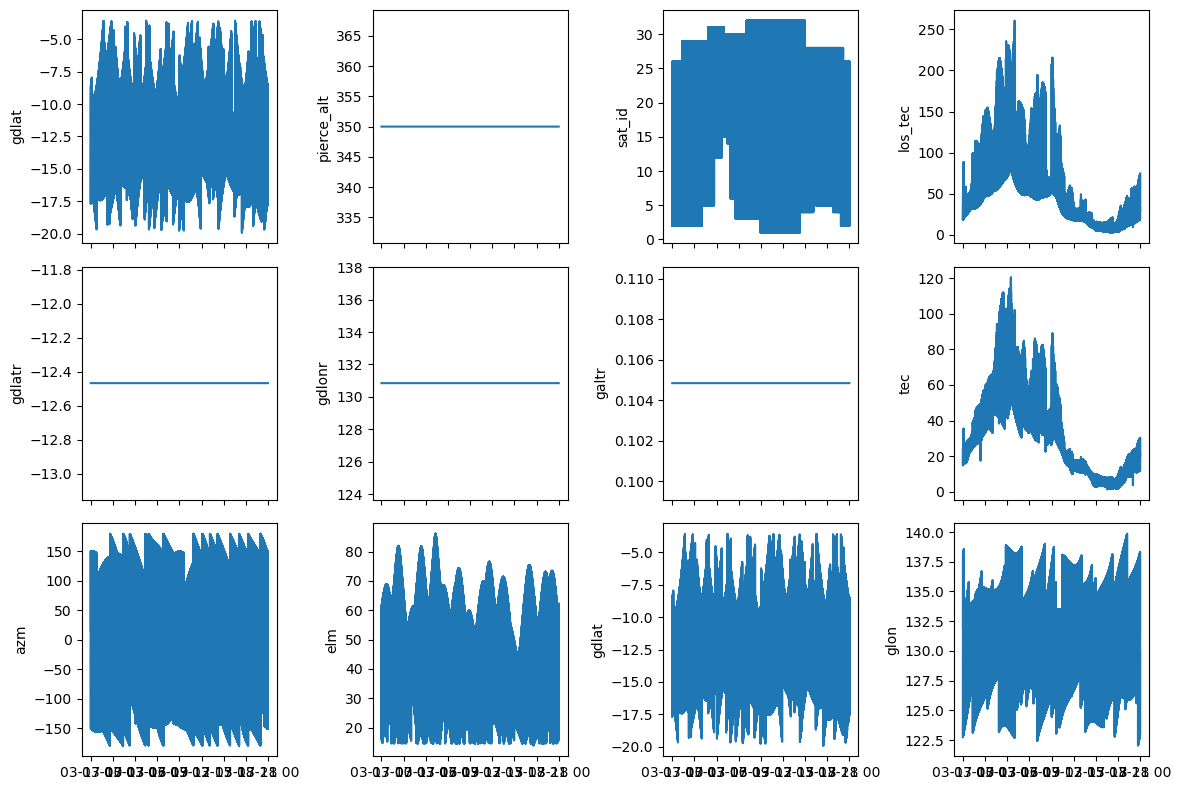

In [151]:
fig, axs = plt.subplots(3,4, figsize=(12,8), sharex=True)

for n, ax in enumerate(axs.flatten()):
    ax.plot(lilds2.time, lilds2[cs[n]].values)
    ax.set_ylabel(cs[n])
    # ax.set_xticks(ax.get_xticks(), rotation=30)
    
fig.tight_layout()
fig.show();

In [157]:
l = [i.groupby('gps_site') for i in list(ds.groupby("sat_id"))]


KeyboardInterrupt



In [161]:
from flox.xarray import xarray_reduce

In [162]:
ds2 = xarray_reduce(ds, 'gps_site', 'sat_id', func="all")


KeyboardInterrupt



In [164]:
ds.nbytes/1024**3

30.028468444943428

In [165]:
tot = len(np.unique(ds.gps_site.values)) * len(np.unique(ds.sat_id.values))

In [166]:
tot

177504

In [169]:
unique_gps_sites = np.unique(ds['gps_site'].values)
unique_sat_ids = np.unique(ds['sat_id'].values)


In [176]:
with tqdm(total = tot) as pbar:
    for gps_site_value in unique_gps_sites:
        for sat_id_value in unique_sat_ids:
            selected_data = ds.where(ds.gps_site==gps_site_value & ds.sat_id==sat_id_value)
            # Process the selected_data as needed
            pbar.update()

  0%|                                                                                                                                                                              | 0/177504 [01:48<?, ?it/s]

KeyboardInterrupt



In [178]:
# Set up the desired coordinates for reindexing
desired_coords = ['time', 'sat_id', 'gps_site']

# Reindex the dataset using the desired coordinates
ds_reindexed = ds.set_index({coord: ds[coord].values for coord in desired_coords + ['idx']})

# Drop the old 'idx' coordinate
ds_reindexed = ds_reindexed.drop('idx')

TypeError: unhashable type: 'numpy.ndarray'

In [104]:
unique_time = np.unique(lilds['time'].values)
unique_sat_id = np.unique(lilds['sat_id'].values)
unique_gps_site =np.unique(lilds['gps_site'].values)

# Create a new index using the unique values
new_index = pd.MultiIndex.from_product([unique_time, unique_sat_id, unique_gps_site],
                                       names=['time', 'sat_id', 'gps_site'])



In [119]:
da_multiindex = lilds.stack(my_multiindex=['time', 'sat_id', 'gps_site'])

da_mean = lilds.groupby("my_multiindex").mean()

KeyError: 'sat_id'

In [114]:
stacked

<xarray.Dataset>
Dimensions:     (idx: 69168, newidx: 69168)
Coordinates:
  * idx         (idx) int64 0 1 2 3 4 5 ... 69162 69163 69164 69165 69166 69167
  * newidx      (newidx) object MultiIndex
  * time        (newidx) datetime64[ns] 2013-03-17 2013-03-17 ... 2013-03-17
Data variables: (12/27)
    year        (idx) float64 2.013e+03 2.013e+03 ... 2.013e+03 2.013e+03
    month       (idx) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0
    day         (idx) float64 17.0 17.0 17.0 17.0 17.0 ... 17.0 17.0 17.0 17.0
    hour        (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    min         (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sec         (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...          ...
    azm         (idx) float64 15.18 68.92 63.54 148.5 ... 77.74 -68.43 -129.3
    elm         (idx) float64 35.53 41.89 16.66 61.09 ... 19.98 53.94 57.09 28.2
    gdlat       (idx) float64 -8.588 -11.28 -8.749 -13.86 ... 50.09 50.35 46.25
    glon        (idx) float64 131.9 133.9 138.2 131.7 ... 22.47 16.43 13.43
    rec_bias    (idx) float64 -23.44 1.106 1.995 -3.974 ... -37.51 -36.78 -44.28
    drec_bias   (idx) float64 1.304 1.308 1.308 1.304 ... 1.301 1.302 1.304

In [105]:
new_index

MultiIndex([('2013-03-17',  1.0, b'00na'),
            ('2013-03-17',  1.0, b'0194'),
            ('2013-03-17',  1.0, b'019b'),
            ('2013-03-17',  1.0, b'01na'),
            ('2013-03-17',  1.0, b'02na'),
            ('2013-03-17',  1.0, b'0ake'),
            ('2013-03-17',  1.0, b'0alf'),
            ('2013-03-17',  1.0, b'0ali'),
            ('2013-03-17',  1.0, b'0amm'),
            ('2013-03-17',  1.0, b'0ana'),
            ...
            ('2013-03-17', 32.0, b'zob1'),
            ('2013-03-17', 32.0, b'zole'),
            ('2013-03-17', 32.0, b'zomb'),
            ('2013-03-17', 32.0, b'zouf'),
            ('2013-03-17', 32.0, b'zpla'),
            ('2013-03-17', 32.0, b'zse1'),
            ('2013-03-17', 32.0, b'zsu4'),
            ('2013-03-17', 32.0, b'ztl4'),
            ('2013-03-17', 32.0, b'zwe2'),
            ('2013-03-17', 32.0, b'zywi')],
           names=['time', 'sat_id', 'gps_site'], length=169694)

In [106]:
lilds

<xarray.Dataset>
Dimensions:     (idx: 69168, time: 69168)
Coordinates:
  * idx         (idx) int64 0 1 2 3 4 5 ... 69162 69163 69164 69165 69166 69167
  * time        (time) datetime64[ns] 2013-03-17 2013-03-17 ... 2013-03-17
Data variables: (12/27)
    year        (idx) float64 2.013e+03 2.013e+03 ... 2.013e+03 2.013e+03
    month       (idx) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0
    day         (idx) float64 17.0 17.0 17.0 17.0 17.0 ... 17.0 17.0 17.0 17.0
    hour        (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    min         (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sec         (idx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...          ...
    azm         (idx) float64 15.18 68.92 63.54 148.5 ... 77.74 -68.43 -129.3
    elm         (idx) float64 35.53 41.89 16.66 61.09 ... 19.98 53.94 57.09 28.2
    gdlat       (idx) float64 -8.588 -11.28 -8.749 -13.86 ... 50.09 50.35 46.25
    glon        (idx) float64 131.9 133.9 138.2 131.7 ... 22.47 16.43 13.43
    rec_bias    (idx) float64 -23.44 1.106 1.995 -3.974 ... -37.51 -36.78 -44.28
    drec_bias   (idx) float64 1.304 1.308 1.308 1.304 ... 1.301 1.302 1.304

In [57]:
ds.groupby('gps_site')


KeyboardInterrupt

